# Speed Graph — PATCHED (2025-08-20T11:30:59)

This patched notebook adds robustness for closed loops:
- **Traction circle slack** (2%) so we don't start exactly on the limit.
- **Seed speed** at 97% of corner-limit.
- **Option to disable TC on braking** (initially off).
- **Cyclic forward/backward** with wrap-around.

**Controls (top of code):**
- `TC_SLACK = 0.02`
- `SEED_SCALE = 0.97`
- `USE_TC_FOR_BRAKING = False`
- `SWEEPS = 8`

Run All to generate plots and CSVs.


## Notebook 1 — Fixed Path

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import math, csv

# --- Tunables ---
TC_SLACK = 0.02           # 2% slack in traction circle
SEED_SCALE = 0.97         # seed below corner-limit
USE_TC_FOR_BRAKING = False
SWEEPS = 8

# --- I/O helpers ---
def save_csv(path, header, array2d):
    with open(path, "w", newline="") as f:
        w = csv.writer(f); w.writerow(header); w.writerows(array2d)

# --- Geometry ---
def arc_length(x, y):
    dx = np.gradient(x); dy = np.gradient(y)
    ds = np.hypot(dx, dy)
    s = np.cumsum(ds); s = np.insert(s, 0, 0.0)[:-1]
    return s, ds

def resample_polyline(x, y, step=1.0):
    s, ds = arc_length(x, y)
    L = s[-1] + ds[-1]
    s_new = np.arange(0, L, step)
    x_new = np.interp(s_new, s, x)
    y_new = np.interp(s_new, s, y)
    return x_new, y_new, s_new

def curvature_from_xy_closed(x, y, eps=1e-9):
    dx  = 0.5*(np.roll(x,-1) - np.roll(x, 1))
    dy  = 0.5*(np.roll(y,-1) - np.roll(y, 1))
    ddx = np.roll(x,-1) - 2*x + np.roll(x,1)
    ddy = np.roll(y,-1) - 2*y + np.roll(y,1)
    denom = (dx*dx + dy*dy)**1.5 + eps
    kappa = (dx*ddy - dy*ddx) / denom
    R = 1.0/np.maximum(np.abs(kappa), eps)
    return kappa, R

def tangents_normals(x, y, eps=1e-9):
    dx = np.gradient(x); dy = np.gradient(y)
    L = np.hypot(dx, dy) + eps
    tx, ty = dx/L, dy/L
    nx, ny = -ty, tx
    return tx, ty, nx, ny

# --- Bike model (simplified) ---
class BikeParams:
    def __init__(self):
        self.rho = 1.225; self.g = 9.81
        self.m = 265.0; self.CdA = 0.35; self.Crr = 0.015
        self.rw = 0.31; self.mu = 1.20
        self.a_wheelie_max = 0.9*self.g
        self.a_brake_max   = 1.2*self.g
        self.shift_rpm = 16000
        self.primary = 1.95; self.final_drive = 2.80
        self.gears = np.array([2.85, 2.12, 1.76, 1.52, 1.39, 1.30])
        self.eta_driveline = 0.92; self.T_peak = 63.0
    def torque_curve(self, rpm): return self.T_peak * np.ones_like(rpm)

def engine_rpm(v, bp, gear):
    omega_w = v / bp.rw
    omega_e = omega_w * bp.primary * bp.final_drive * gear
    return omega_e * 60/(2*np.pi)

def wheel_force(v, bp, gear):
    T = bp.torque_curve(engine_rpm(v, bp, gear))
    G = bp.primary * bp.final_drive * gear
    return (T * G * bp.eta_driveline) / bp.rw

def aero_drag(v, bp): return 0.5*bp.rho*bp.CdA*v*v
def roll_res(bp):     return bp.Crr*bp.m*bp.g

def traction_circle_cap(v, Rlocal, bp, eps_tc=TC_SLACK):
    Rlocal = np.maximum(Rlocal, 1.0)
    a_lat = (v*v)/Rlocal
    inside = (bp.mu*bp.g)**2 * (1.0 - eps_tc) - a_lat*a_lat
    return np.sqrt(np.maximum(0.0, inside))

# --- Solvers ---
def seed_corner_speed(R, bp):
    v_corner = np.sqrt(np.maximum(0.0, bp.mu*bp.g*np.maximum(R, 1.0)))
    return SEED_SCALE * v_corner

def solve_forward_only(x, y, bp):
    s, ds = arc_length(x, y); _, R = curvature_from_xy_closed(x, y)
    v = seed_corner_speed(R, bp)
    for i in range(len(s)-1):
        Fw = wheel_force(v[i], bp, bp.gears[0])
        a_pow = (Fw - aero_drag(v[i], bp) - roll_res(bp))/bp.m
        a_pow = np.clip(a_pow, -bp.a_brake_max, bp.a_wheelie_max)
        v[i+1] = min(v[i+1], np.sqrt(max(0.0, v[i]**2 + 2*a_pow*ds[i])))
    return s, v, R

def solve_speed_profile_closed(x, y, bp, use_traction_circle=True, sweeps=SWEEPS):
    N = len(x)
    s, ds = arc_length(x, y); _, R = curvature_from_xy_closed(x, y)
    v = seed_corner_speed(R, bp)
    ds_wrap = float(np.hypot(x[0]-x[-1], y[0]-y[-1]))
    for _ in range(sweeps):
        # forward
        for i in range(N-1):
            Fw = wheel_force(v[i], bp, bp.gears[0])
            a_pow = (Fw - aero_drag(v[i], bp) - roll_res(bp))/bp.m
            a_pow = np.clip(a_pow, -bp.a_brake_max, bp.a_wheelie_max)
            if use_traction_circle:
                a_pow = np.minimum(a_pow, traction_circle_cap(v[i], R[i], bp))
            v[i+1] = min(v[i+1], np.sqrt(max(0.0, v[i]**2 + 2*a_pow*ds[i])))
        # wrap forward
        Fw = wheel_force(v[-1], bp, bp.gears[0])
        a_pow = (Fw - aero_drag(v[-1], bp) - roll_res(bp))/bp.m
        a_pow = np.clip(a_pow, -bp.a_brake_max, bp.a_wheelie_max)
        if use_traction_circle:
            a_pow = np.minimum(a_pow, traction_circle_cap(v[-1], R[-1], bp))
        v[0] = min(v[0], np.sqrt(max(0.0, v[-1]**2 + 2*a_pow*ds_wrap)))

        # backward
        for i in range(N-2, -1, -1):
            a_brk = bp.a_brake_max
            if use_traction_circle and USE_TC_FOR_BRAKING:
                a_brk = min(a_brk, traction_circle_cap(v[i+1], R[i+1], bp))
            v[i] = min(v[i], np.sqrt(max(0.0, v[i+1]**2 + 2*(a_brk)*ds[i])))
        # wrap back
        a_brk = bp.a_brake_max
        if use_traction_circle and USE_TC_FOR_BRAKING:
            a_brk = min(a_brk, traction_circle_cap(v[0], R[0], bp))
        v[-1] = min(v[-1], np.sqrt(max(0.0, v[0]**2 + 2*(a_brk)*ds_wrap)))
    lap_time = float(np.sum((np.r_[ds[:-1], ds_wrap]) / np.maximum(v, 1e-3)))
    return s, v, R, lap_time

def solve_speed_profile_open(x, y, bp, use_traction_circle=True):
    s, ds = arc_length(x, y); _, R = curvature_from_xy_closed(x, y)
    v = seed_corner_speed(R, bp)
    for i in range(len(s)-1):
        Fw = wheel_force(v[i], bp, bp.gears[0])
        a_pow = (Fw - aero_drag(v[i], bp) - roll_res(bp))/bp.m
        a_pow = np.clip(a_pow, -bp.a_brake_max, bp.a_wheelie_max)
        if use_traction_circle:
            a_pow = np.minimum(a_pow, traction_circle_cap(v[i], R[i], bp))
        v[i+1] = min(v[i+1], np.sqrt(max(0.0, v[i]**2 + 2*a_pow*ds[i])))
    for i in range(len(s)-2, -1, -1):
        a_brk = bp.a_brake_max
        if use_traction_circle and USE_TC_FOR_BRAKING:
            a_brk = min(a_brk, traction_circle_cap(v[i+1], R[i+1], bp))
        v[i] = min(v[i], np.sqrt(max(0.0, v[i+1]**2 + 2*(a_brk)*ds[i])))
    lap_time = float(np.sum(ds / np.maximum(v, 1e-3)))
    return s, v, R, lap_time

def solve_speed_profile_auto(x, y, bp, use_traction_circle=True):
    seam = float(np.hypot(x[0]-x[-1], y[0]-y[-1]))
    if seam > 3.0:
        return solve_speed_profile_open(x, y, bp, use_traction_circle)
    else:
        return solve_speed_profile_closed(x, y, bp, use_traction_circle)

def plot_xy(x, y, title):
    plt.figure(); plt.plot(x, y, lw=2); plt.axis("equal")
    plt.title(title); plt.xlabel("x [m]"); plt.ylabel("y [m]"); plt.show()

def plot_sv(s, v, title):
    plt.figure(); plt.plot(s, v, lw=2)
    plt.title(title); plt.xlabel("s (m)"); plt.ylabel("speed (m/s)"); plt.show()

# --- Sample track ---
def sample_track():
    theta = np.linspace(0, 2*np.pi, 1600, endpoint=False)
    R0 = 300.0
    x = R0*np.cos(theta); y = 0.8*R0*np.sin(theta)
    y += 80*np.exp(-((x-250)/60)**2) * np.exp(-((y)/120)**2)
    x += 30*np.exp(-((y+120)/40)**2)
    return resample_polyline(x, y, step=1.0)


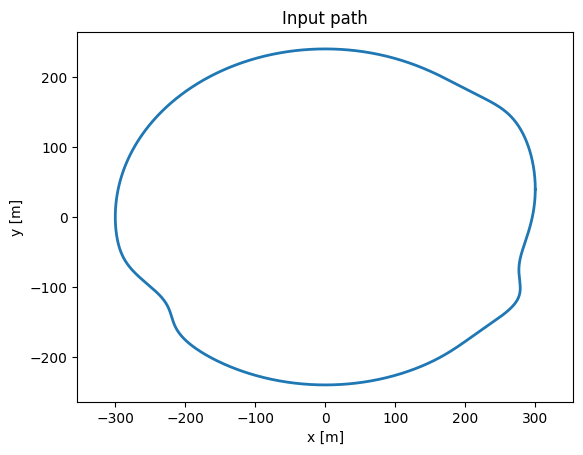

In [ ]:

# ---- Choose data: sample path or your own CSV ----
USE_SAMPLE = False

if USE_SAMPLE:
    x, y, s = sample_track()[:3]
else:
    csv_path = "MallalaRacingLineUS.csv"  # columns: x,y
    xs, ys = [], []
    with open(csv_path) as f:
        rdr = csv.reader(f)
        header = next(rdr, None)
        if header:
            try:
                float(header[0]); xs.append(float(header[0])); ys.append(float(header[1]))
            except:
                pass
        for row in rdr:
            xs.append(float(row[0])); ys.append(float(row[1]))
    x = np.array(xs); y = np.array(ys)
    # clean & resample
    mask = np.r_[True, np.hypot(np.diff(x), np.diff(y)) > 1e-6]
    x, y = x[mask], y[mask]
    x, y, s = resample_polyline(x, y, step=1.0)

bp = BikeParams()
plot_xy(x, y, "Input path")


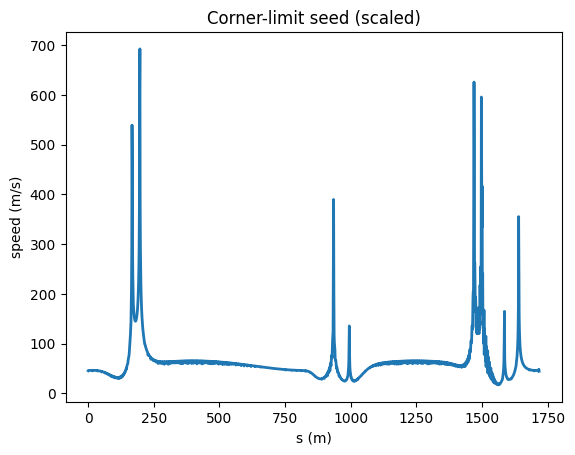

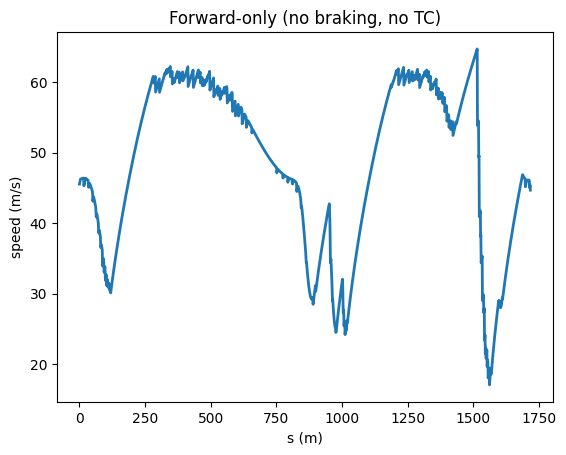

In [3]:

# --- Diagnostics: corner seed & forward-only ---
kappa, R = curvature_from_xy_closed(x, y)
v_corner = seed_corner_speed(R, bp)
plot_sv(s, v_corner, "Corner-limit seed (scaled)")

sF, vF, _ = solve_forward_only(x, y, bp)
plot_sv(sF, vF, "Forward-only (no braking, no TC)")


Lap time (const-corner): 39.12 s
Lap time (traction-circle): 39.44 s
Zeros in v_const: 0
Zeros in v_trac:  0
Wrote speed_graph_fixed_path.csv


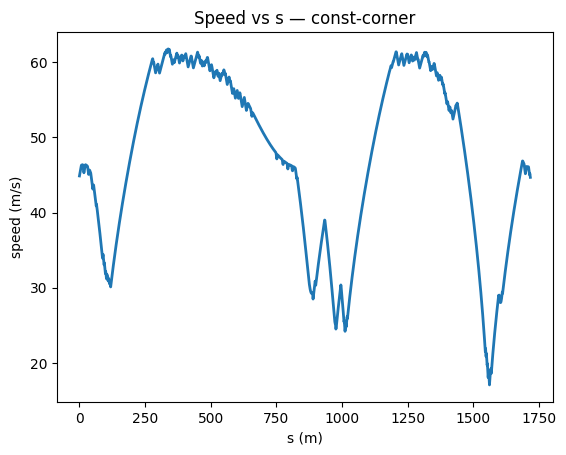

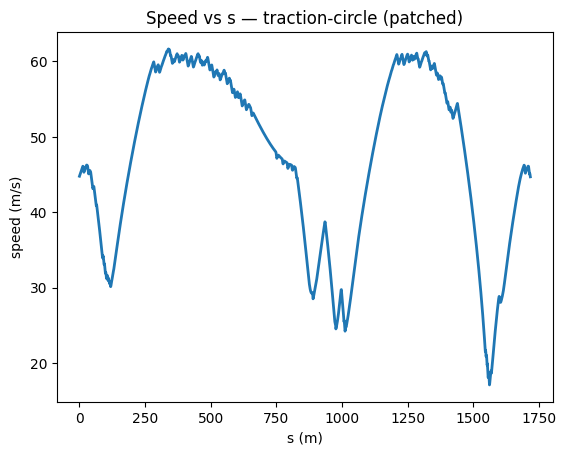

In [4]:

# --- Final profiles: const-corner & traction-circle ---
s1, v_const, R1, t_const = solve_speed_profile_auto(x, y, bp, use_traction_circle=False)
s2, v_trac,  R2, t_trac  = solve_speed_profile_auto(x, y, bp, use_traction_circle=True)

print(f"Lap time (const-corner): {t_const:.2f} s")
print(f"Lap time (traction-circle): {t_trac:.2f} s")
print("Zeros in v_const:", int(np.count_nonzero(v_const<1e-6)))
print("Zeros in v_trac: ", int(np.count_nonzero(v_trac<1e-6)))

# Save CSV
arr = np.vstack([s1, v_const, v_trac, R1]).T
save_csv("speed_graph_fixed_path.csv", ["s_m","v_const_mps","v_trac_mps","R_m"], arr)
print("Wrote speed_graph_fixed_path.csv")

# Plots
plot_sv(s1, v_const, "Speed vs s — const-corner")
plot_sv(s2, v_trac,  "Speed vs s — traction-circle (patched)")
